# Analysis of Locomotion Rhythms using Pynapple

### raw data -> clean data -> filtered data -> FFT -> PSD -> MWT -> power envelope/CVE -> ... correlation, PLV

1. Clean data - background subtraction, normalization
2. Filtered data - create Pynapple tsdframe for smoothing, **highpass/bandpass filter
3. FFT, PSD, **PSD-thresholding - using Pynapple, return which signals have loco frequency.
4. MWT - a closer look of PSD at specific frequency band

DRAFT WORKS

5. Power envelope and coefficient of variation of the envelope (CVE) - determine if signal is rhythmic, Gaussian (noise), or phasic
3. Correlation - determine synchronicity with lumbar nerve
4. Phase locking value (PLV) - polar plot

# Import

In [96]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from scipy.fft import fft, fft2, ifft, ifft2, fftfreq
from scipy import signal
from scipy.signal import welch
from scipy import integrate
from scipy.signal import hilbert
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import seaborn as sns
import pynapple as nap

# Read CSV file ***

In [30]:
file = "AU20250716-xyt1"
data = pd.read_csv(f"/Users/araya/Sync/LAB SG/DBX1 Analysis/{file}.csv",
                   na_values=[' '])

# This returns a pd dataframe
# Note: If data CSV is generated with column headers,remove header=None from parameters in pd.read_csv

# Fill None/NaN values in nerve1 and nerve2 with the previous value
data = data.ffill()
#data = data.fillna(0)

data_float = np.array(data)
#print(data)

# Set Parameters (T, background_roi) ***

In [31]:
# Define time using number of samples (N) and sample spacing (T)
N = len(data)                       # Experimental parameter: 400 frames
T = 0.277                           # Experimental parameter: 277 ms per frame
fs = 1/T                            # fs = sampling rate in Hz
#time = np.arange(0, N*T, T)        # Generate time series from 0 to N*T seconds at sampling interval T
                                    # Don't need if there is already a time column on CSV file

# Define ROIs
background_roi = 21
stop_index = background_roi + 2 + 1

# Extract time column and data columns
time = data.iloc[:, 0].values                              # time: first column index 0
signals = data.iloc[:, 1:stop_index].values                # This include nerves and ROIs from index 1 upto but not including stop_index. Index 3 = ROI 1
background = data.iloc[:, background_roi + 2].values   

# Background subtraction
- Background subtraction is a general pre-processing of data.
- Spectral subtraction (in PSD freqency domain) is also a form of background removal.
- Nonetheless, general signal processing might be necessary to improve the accuracy of the spectral subtraction or PSD estimate. 

In [32]:
# Define background
bg_index = signals.shape[1] - 1           # return index of background
last_index = signals.shape[1]             # return number of columns from index 0 to index of background

df = pd.DataFrame(signals)

# Specify the columns to subtract from
target_columns = list(range(2, last_index))     # indices 0 and 1 are the 2 nerve signals - not subtracted by image background ROI

# Subtract background ROI from the target columns
for col in target_columns:
    df[col] = df[col] - df[bg_index]

# Normalization to min/max

In [33]:
# df from above is a dataframe of nerve signals and background subtracted ROI signals

# Apply Min-Max Normalization to each column
df_norm = (df - df.min()) / (df.max() - df.min())

df_norm = df_norm.fillna(0)

# Convert dataframe to np.array
data_norm = df_norm.to_numpy()

# Create TsdFrame from Background-Subtracted/Normalized Data

In [34]:
tsdframe = nap.TsdFrame(t=time, d=data_norm)
#print(tsdframe)

### Defining columns in Tsdframe

In [35]:
nerve1 = tsdframe.loc[0]
nerve2 = tsdframe.loc[1]

### Smoothing ~ Rolling

In [36]:
# a tsd is convolved with a gaussian kernel. 
# The standard deviation is 1 second and the windowsize is 1 second.

smooth_tsdframe = tsdframe.smooth(std=1, windowsize=1, time_units='s', norm=False)

# Highpass/bandpass filter (set filter frequency) ***

In [9]:
# Bandpass filter

#filter_tsdframe = nap.apply_bandpass_filter(smooth_tsdframe, (0.1, 1), fs = 1/T, mode='butter') 

# **** Filter from 0.2 or T (around 0.25-0.3) instead of <0.1 give roi trace more distinct oscillation ****
# Filter between 0.01 and 1 Hz at sampling rate 1/T Hz
# Digital filter critical frequencies must be 0 < Wn < fs/2

In [37]:
# Highpass filter

highpass_freq = 0.2
filter_tsdframe = nap.apply_highpass_filter(smooth_tsdframe, highpass_freq, fs=None, mode='butter', order=4, transition_bandwidth=0.02)

### Comparing Bandpass Filtered Signals vs Smoothed Signals vs Raw Signals

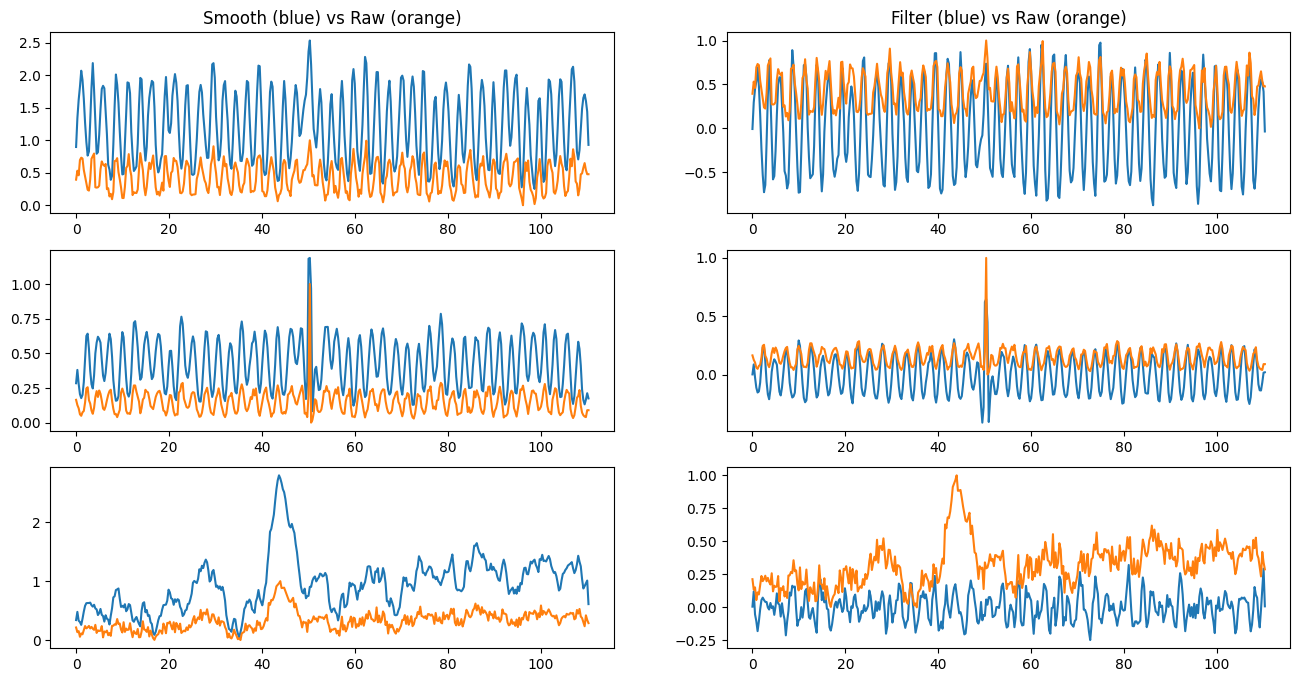

In [38]:
# Define ROI to plot
roi_index = 2

# Plot Smooth vs Raw
fig, axs = plt.subplots(3,2, figsize=(16, 8))               # set plot axes to (rows, columns, figure size)

axs[0,0].set_title("Smooth (blue) vs Raw (orange)")
plt.sca(axs[0,0])                          # .sca set current axis
plt.plot(smooth_tsdframe.loc[0])           # nerve1 smooth
plt.plot(tsdframe.loc[0])                  # nerve1 raw
plt.sca(axs[1,0])
plt.plot(smooth_tsdframe.loc[1])           # nerve2 smooth
plt.plot(tsdframe.loc[1])                  # nerve2 raw
plt.sca(axs[2,0])
plt.plot(smooth_tsdframe.loc[roi_index])   # roi smooth
plt.plot(tsdframe.loc[roi_index])          # roi raw

# Plot Filter vs Raw
axs[0,1].set_title("Filter (blue) vs Raw (orange)")
plt.sca(axs[0,1])                            
plt.plot(filter_tsdframe.loc[0])           # nerve1 smooth
plt.plot(tsdframe.loc[0])                  # nerve1 raw
plt.sca(axs[1,1])
plt.plot(filter_tsdframe.loc[1])           # nerve2 smooth
plt.plot(tsdframe.loc[1])                  # nerve2 raw
plt.sca(axs[2,1])
plt.plot(filter_tsdframe.loc[roi_index])   # roi smooth
plt.plot(tsdframe.loc[roi_index])          # roi raw
plt.show()

- ??? Am I forcing oscillations to the signal where there are none by doing bandpass filter?????
- See Google: does bandpass filter make signal more oscillatory? vs De Cheveigné and Nelken, Neuron 2019, Filters: When, Why, and How (not) to use them
- Does highpass filter cause less ringing (oscillatory response)?

# Power Spectral Density
- Normalize the signals before doing PSD because signal amplitude does affect PSD results, i.e. power is related to the square of the amplitude.

### PSD of raw signals

Text(0, 0.5, 'Power/Frequency')

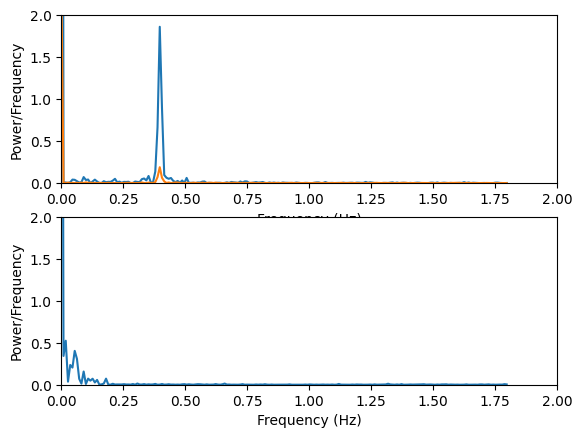

In [12]:
# From raw signals
nerve1 = tsdframe.loc[0]
nerve2 = tsdframe.loc[1]
roi = tsdframe.loc[2]

psd_nerve1 = nap.compute_power_spectral_density(nerve1, fs=1/T)
psd_nerve2 = nap.compute_power_spectral_density(nerve2, fs=1/T)
psd_roi = nap.compute_power_spectral_density(roi, fs=1/T)

fig, axs = plt.subplots(2,1) 
plt.sca(axs[0])
plt.plot(psd_nerve1)
plt.plot(psd_nerve2)
plt.xlim(0, 2)
plt.ylim(0, 2)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power/Frequency")

plt.sca(axs[1])
plt.plot(psd_roi)
plt.xlim(0, 2)
plt.ylim(0, 2)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power/Frequency")


### PSD of filtered signals

Text(0, 0.5, 'Power/Frequency')

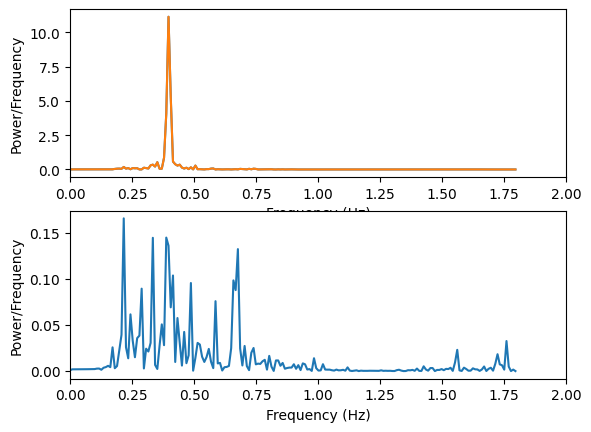

In [13]:
nerve1_filtered = filter_tsdframe.loc[0]
nerve2_filtered = filter_tsdframe.loc[1]
roi_filtered = filter_tsdframe.loc[3]

psd_nerve1_filtered = nap.compute_power_spectral_density(nerve1_filtered, fs=1/T)
psd_nerve2_filtered = nap.compute_power_spectral_density(nerve1_filtered, fs=1/T)
psd_roi_filtered = nap.compute_power_spectral_density(roi_filtered, fs=1/T)

fig, axs = plt.subplots(2,1) 
plt.sca(axs[0])
plt.plot(psd_nerve1_filtered)
plt.plot(psd_nerve2_filtered)
plt.xlim(0, 2)
#plt.ylim(0, 2)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power/Frequency")

plt.sca(axs[1])
plt.plot(psd_roi_filtered)
plt.xlim(0, 2)
#plt.ylim(0, 2)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power/Frequency")


### Mean PSD of filtered signals - Smooth out the noise of PSD

In [14]:
# Define ROI
roi_filtered = filter_tsdframe.loc[3]

mean_psd_nerve1_filtered = nap.compute_mean_power_spectral_density(nerve1_filtered, interval_size=100*T, fs=1/T)
mean_psd_nerve2_filtered = nap.compute_mean_power_spectral_density(nerve2_filtered, interval_size=100*T, fs=1/T)
mean_psd_roi_filtered = nap.compute_mean_power_spectral_density(roi_filtered, interval_size=100*T, fs=1/T)

# Return mean power spectral density of the input signal. 
# Indexes are frequencies and values are powers/frequency.
# Return pandas.DataFrame

mean_psd_roi = pd.DataFrame()
filtered_roi = list(range(2, last_index))                # specify indices of all ROIs

for roi in filtered_roi:
    mean_psd_roi_filtered = nap.compute_mean_power_spectral_density(smooth_tsdframe.loc[roi], interval_size=100*T, fs=1/T)
    mean_psd_roi[roi] = mean_psd_roi_filtered

#print(mean_psd_roi)
    
# write DataFrame to an excel sheet 
# mean_psd_roi.to_excel('mean_psd_roi.xlsx')

(0.0, 1.0)

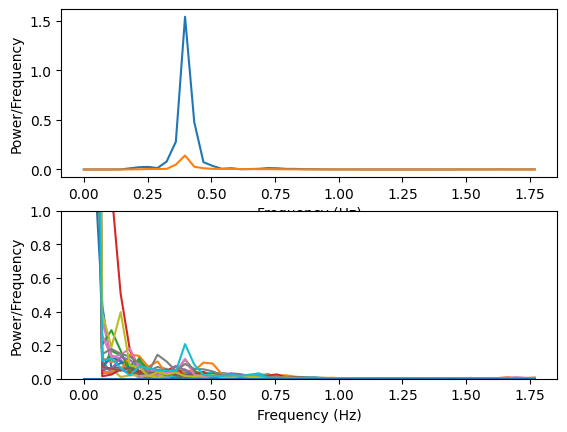

In [15]:
# Plot
fig, axs = plt.subplots(2,1) 
plt.sca(axs[0])
plt.plot(mean_psd_nerve1_filtered)
plt.plot(mean_psd_nerve2_filtered)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power/Frequency")

plt.sca(axs[1])
plt.plot(mean_psd_roi)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power/Frequency")
plt.ylim(0, 1)

In [16]:
# If pull out only the loco frequency, will the correlation get better?
# What's the slow frequency?

Nerve1, nerve2, roi1 to roi20, background: roi21


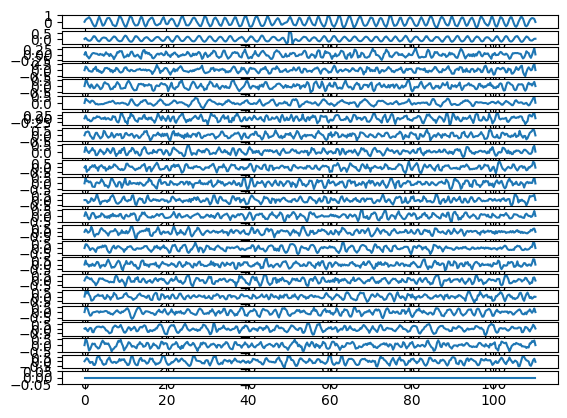

In [17]:
# Plot all traces

fig, axs = plt.subplots(last_index,1) 
for i in range(last_index):
    plt.sca(axs[i])
    plt.plot(filter_tsdframe.loc[i])

print(f"Nerve1, nerve2, roi1 to roi{last_index - 3}, background: roi{last_index - 2}")

# Pynapple FFT and PSD Thresholding

### FFT

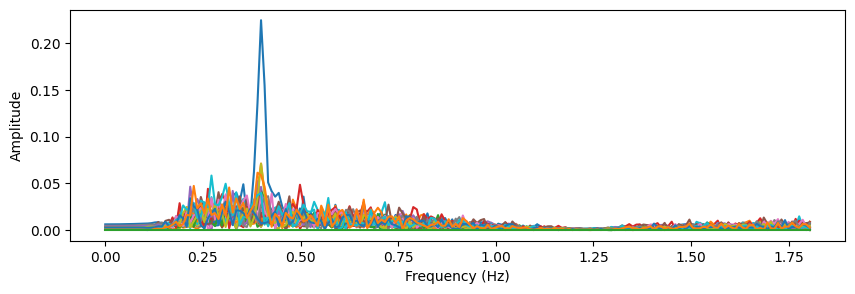

In [39]:
# Pynapple FFT
fft = nap.compute_fft(filter_tsdframe, norm=True)     # Pynapple returns a pandas DataFrame

plt.subplots(figsize=(10, 3))
plt.plot(np.abs(fft))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.show()

### PSD of Background ROI is ~0. Do not need this for subtraction or thresholding

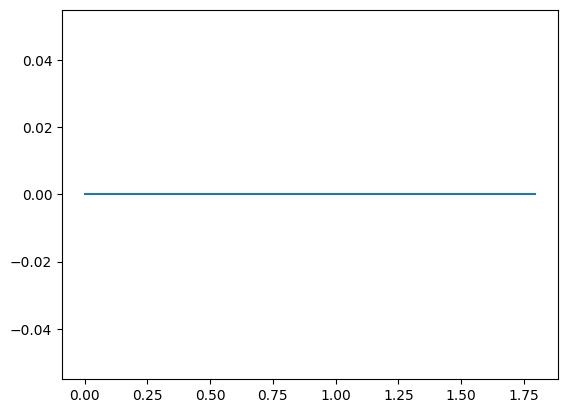

In [19]:
# PSD of Background ROI

PSD_background = nap.compute_power_spectral_density(filter_tsdframe.loc[bg_index], fs=1/T)
plt.plot(PSD_background)

# PSD of background ROI is ~0. So, will not use this for subtraction or thresholding.

### PSD Thresholding (set PSD_threshold) ***
- A broad, flat PSD suggests random noise, while distinct peaks indicate true oscillatory frequencies.

Indices with locomotion frequency: [0, 1, 13, 14, 18, 19, 21]


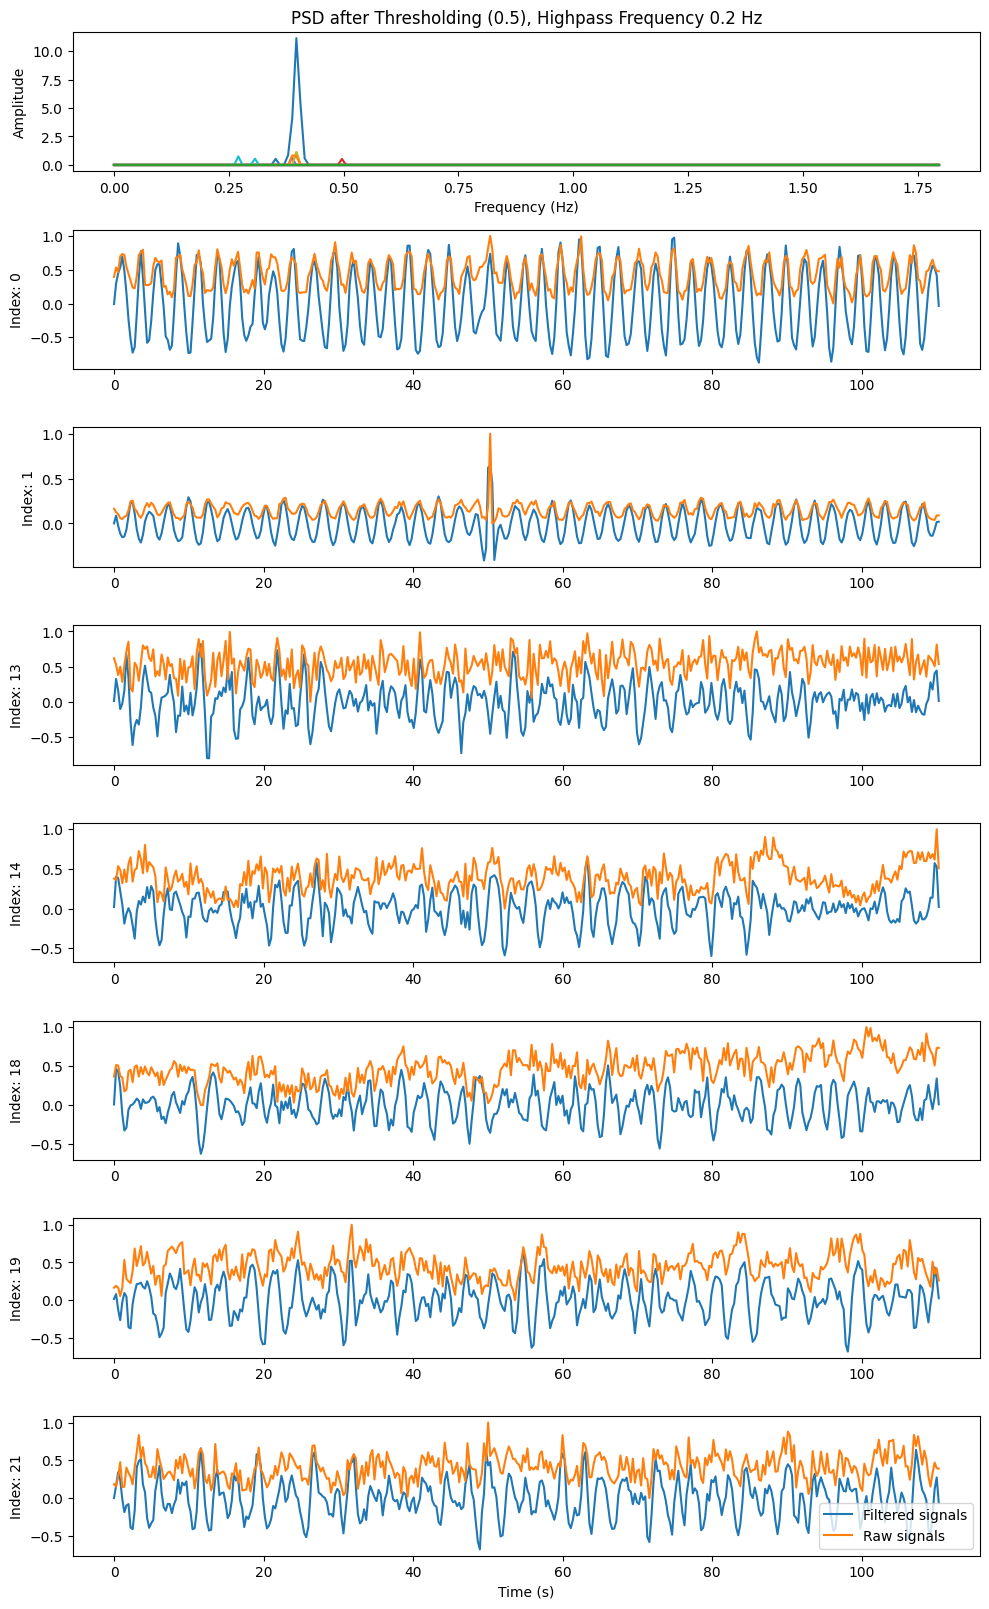

In [40]:
# Pyanpple PSD
PSD = nap.compute_power_spectral_density(filter_tsdframe, fs=1/T)    # This returns a pandas DataFrame

# Thresholding
PSD_threshold = 0.5
indices = PSD > PSD_threshold               # **Use minimal PSD threshold that yields only loco frequency
PSDclean = PSD * indices                    # zero out frequencies with PSD below threshold
fftclean = indices * 0.1 * fft              # zero out small fourier coefficent in Y, with scaling -- may not need this

# Finding index of column that has the main locomotion frequency
non_zero_columns_index = (PSDclean != 0).any()                           # return boolean datatype
true_indices_np = np.where(non_zero_columns_index)[0].tolist()
print(f"Indices with locomotion frequency: {true_indices_np}")

# Plot column that has the main locomotion frequency
nrows = len(true_indices_np) + 1
ncols = 1
fig, axs = plt.subplots(nrows, ncols, figsize=(10, nrows*2)) 

axs[0].plot(PSDclean)
axs[0].set_title(f"PSD after Thresholding ({PSD_threshold}), Highpass Frequency {highpass_freq} Hz")
axs[0].set_xlabel("Frequency (Hz)")
axs[0].set_ylabel("Amplitude")

for i in range(len(true_indices_np)): 
    axs[i+1].plot(filter_tsdframe.loc[true_indices_np[i]], label='Filtered signals')
    axs[i+1].plot(tsdframe.loc[true_indices_np[i]], label='Raw signals')
    axs[i+1].set_ylabel(f"Index: {true_indices_np[i]}")

plt.tight_layout()
plt.legend()
plt.xlabel("Time (s)")
plt.savefig(f"/Users/araya/Sync/LAB SG/DBX1 Jupyter/{file}.jpg", dpi=300)
plt.show()

# Frequency at the maximum power

In [41]:
# From PSD dataframe
frequency_at_max_PSD = PSD.idxmax(axis=0)
frequency_at_max_PSDclean = PSDclean.idxmax(axis=0)    # After thresholding

PSD_results = pd.concat([frequency_at_max_PSD, frequency_at_max_PSDclean], axis=1)
PSD_results.columns = ['Freq at Max PSD', 'Freq at Max PSDclean']

print(PSD_results)
print(f"Highpass frequency set at {highpass_freq}")
print(f"PSD threshold set at {PSD_threshold}")

    Freq at Max PSD  Freq at Max PSDclean
0          0.397112              0.397112
1          0.397112              0.397112
2          0.306859              0.000000
3          0.216606              0.000000
4          0.397112              0.000000
5          0.243682              0.000000
6          0.315884              0.000000
7          0.261733              0.000000
8          0.388087              0.000000
9          0.270758              0.000000
10         0.415162              0.000000
11         0.478339              0.000000
12         0.397112              0.000000
13         0.496390              0.496390
14         0.388087              0.388087
15         0.288809              0.000000
16         0.424188              0.000000
17         0.415162              0.000000
18         0.397112              0.397112
19         0.270758              0.270758
20         0.216606              0.000000
21         0.388087              0.388087
22         0.000000              0

In [42]:
equal_list = []
list1 = []
list2 = []
list3 = []
list4 = []
list5 = []

for i in range(2, last_index):
    if frequency_at_max_PSD[i] == frequency_at_max_PSD[0]:
        equal_list.append(i)
    elif 0.6 <= frequency_at_max_PSD[i] < 0.8:
        list1.append(i)
    elif 0.4 <= frequency_at_max_PSD[i] < 0.6:
        list2.append(i)
    elif 0.2 <= frequency_at_max_PSD[i] < 0.4:
        list3.append(i)
    elif 0 <= frequency_at_max_PSD[i] < 0.2:
        list4.append(i)
    else:
        list5.append(i)

print(f"ROIs with max frequency = loco frequency = {frequency_at_max_PSD[0]}: {equal_list} ")
print(f"ROIs with max frequency between 0.6 and 0.8 Hz: {list1}")
print(f"ROIs with max frequency between 0.4 and 0.6 Hz: {list2}")
print(f"ROIs with max frequency between 0.2 and 0.4 Hz: {list3}")
print(f"ROIs with max frequency between 0 and 0.2 Hz: {list4}")
print(f"ROIs with max frequency > loco frequency: {list5}")

ROIs with max frequency = loco frequency = 0.3971119133574007: [4, 12, 18] 
ROIs with max frequency between 0.6 and 0.8 Hz: []
ROIs with max frequency between 0.4 and 0.6 Hz: [10, 11, 13, 16, 17]
ROIs with max frequency between 0.2 and 0.4 Hz: [2, 3, 5, 6, 7, 8, 9, 14, 15, 19, 20, 21]
ROIs with max frequency between 0 and 0.2 Hz: [22]
ROIs with max frequency > loco frequency: []


 # Correlation

In [43]:
# DataFrame correlation matrix

# Convert TsdFrame object to pandas.DataFrame object
filter_df = filter_tsdframe.as_dataframe()

# Comput correlation matrix
correlation_matrix = filter_df.corr().round(3)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print(correlation_matrix)

       0      1      2      3      4      5      6      7      8      9   \
0   1.000 -0.812  0.039 -0.102  0.158 -0.075 -0.021  0.098 -0.166 -0.163   
1  -0.812  1.000  0.011  0.151 -0.122  0.023  0.046 -0.074  0.161  0.083   
2   0.039  0.011  1.000  0.122 -0.010 -0.035  0.100  0.178  0.085  0.156   
3  -0.102  0.151  0.122  1.000  0.259  0.038  0.072  0.142 -0.013  0.179   
4   0.158 -0.122 -0.010  0.259  1.000  0.143  0.074  0.090 -0.197  0.052   
5  -0.075  0.023 -0.035  0.038  0.143  1.000  0.134  0.091  0.119  0.157   
6  -0.021  0.046  0.100  0.072  0.074  0.134  1.000  0.138  0.060  0.022   
7   0.098 -0.074  0.178  0.142  0.090  0.091  0.138  1.000  0.072  0.099   
8  -0.166  0.161  0.085 -0.013 -0.197  0.119  0.060  0.072  1.000  0.143   
9  -0.163  0.083  0.156  0.179  0.052  0.157  0.022  0.099  0.143  1.000   
10  0.082 -0.035 -0.097  0.044  0.064 -0.005  0.058  0.016 -0.017 -0.021   
11 -0.051 -0.028  0.037  0.209 -0.088  0.110  0.059  0.195  0.079  0.091   
12 -0.102  0

# Saving Results

In [44]:
with open(f"/Users/araya/Sync/LAB SG/DBX1 Jupyter/{file}.txt", "w") as f:
    print(f"File: {file}", file=f)
    f.write("\n")
    print(f"{N} frames, {T} mspf, {fs} Hz", file=f)
    f.write("\n")
    print(f"Highpass frequency set at {highpass_freq}", file=f)
    print(f"PSD threshold set at {PSD_threshold}", file=f)
    f.write("\n")
    print(f"Indices with locomotion frequency: {true_indices_np}", file=f)
    f.write("\n")
    print(PSD_results, file=f)
    f.write("\n")
    print(f"ROI indices with max frequency = loco frequency = {frequency_at_max_PSD[0]}: {equal_list}", file=f)
    print(f"ROI indices with max frequency 0.6 - 0.8 Hz: {list1}", file=f)
    print(f"ROI indices with max frequency 0.4 - 0.6 Hz: {list2}", file=f)
    print(f"ROI indices with max frequency 0.2 - 0.4 Hz: {list3}", file=f)
    print(f"ROI indices with max frequency 0 - 0.2 Hz: {list4}", file=f)
    print(f"ROI indices with max frequency > loco frequency: {list5}", file=f)
    f.write("\n")
    print("Correlation Matrix", file=f)
    f.write("\n")
    print(correlation_matrix, file=f)

# Wavelet Transform using Pynapple
- Continuous wavelet transform (CWT) decomposes the signals to look more closely at particular frequencies and time
- Of note, filtering can affect CWT outcome

### Wavelet Decomposition (define signal i)

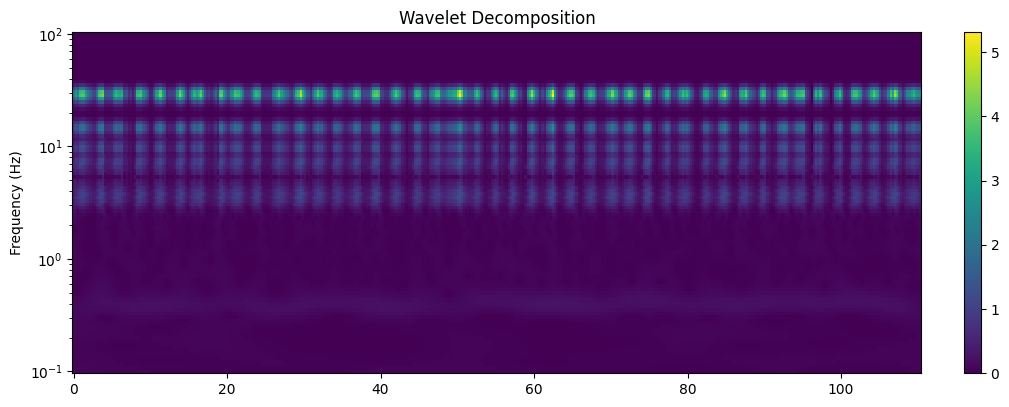

In [45]:
# Define the frequency set that we'd like to use for our decomposition
freqs = np.geomspace(0.1, 100, 100)  # Generate frequency ranges in logarithmic scal from 1 to 100 in 20 steps

# filter_tsdframe.loc[i] = Background subtracted/normalized/smooth/highpass filtered data      
# tsdframe.loc[i] = Background subtracted/normalized data

# Define which signal to see
i = 0

# Comput Morlet wavelet transform (MWT)
MWT_filter = nap.compute_wavelet_transform(filter_tsdframe.loc[i], fs=fs, freqs=freqs)
MWT = nap.compute_wavelet_transform(tsdframe.loc[i], fs=fs, freqs=freqs)

# Plot
fig = plt.figure(constrained_layout=True, figsize=(10, 6))
gs = plt.GridSpec(3, 1, figure=fig, height_ratios=[1.0, 0.5, 0.1])

ax0 = plt.subplot(gs[0, 0])
pcmesh = ax0.pcolormesh(MWT.t, freqs, np.transpose(np.abs(MWT)))
ax0.grid(False)
ax0.set_yscale("log")
ax0.set_title("Wavelet Decomposition")
ax0.set_ylabel("Frequency (Hz)")
cbar = plt.colorbar(pcmesh, ax=ax0, orientation="vertical")

### Morlet Wavelet Transform (MWT) for Specified Frequency Band
- MWT of filtered vs unfiltered signals are similar, only differ in amplitudes
- Here, use unfiltered signals for MWT analysis

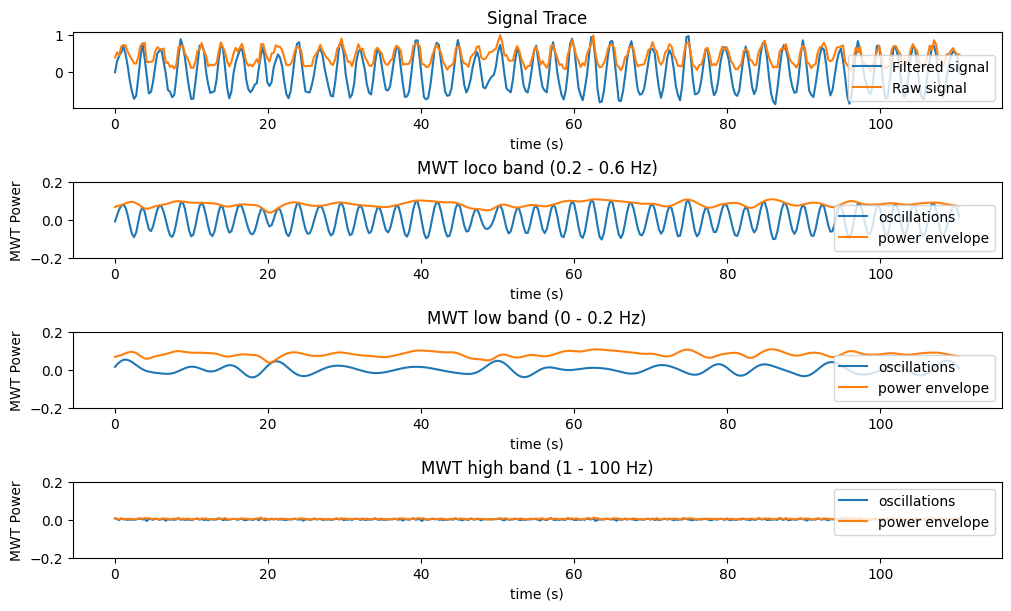

In [49]:
# Set frequency band to look at
from_freq = 0.2
to_freq = 0.6

low_freq_index = np.logical_and(freqs > 0, freqs < 0.2)
loco_freq_index = np.logical_and(freqs > from_freq, freqs < to_freq)
high_freq_index = np.logical_and(freqs > 1, freqs < 100)

# Extract its real component, as well as its power envelope
loco_band_reconstruction = np.mean(MWT[:, loco_freq_index], 1)     # Power of signal in loco frequency band
loco_band_power_envelope = np.abs(loco_band_reconstruction)

low_band_reconstruction = np.mean(MWT[:, low_freq_index], 1)
low_band_power_envelope = np.abs(low_band_reconstruction)

high_band_reconstruction = np.mean(MWT[:, high_freq_index], 1)
high_band_power_envelope = np.abs(high_band_reconstruction)

# Plot
fig = plt.figure(constrained_layout=True, figsize=(10, 6))
gs = plt.GridSpec(4, 1, figure=fig)

ax0 = plt.subplot(gs[0, 0])
ax0.plot(filter_tsdframe.loc[i], label="Filtered signal")
ax0.plot(tsdframe.loc[i], label="Raw signal")
ax0.set_title("Signal Trace")
ax0.set_xlabel("time (s)")
ax0.legend()

ax1 = plt.subplot(gs[1, 0])
ax1.plot(np.real(loco_band_reconstruction), label="oscillations")
ax1.set_title(f"MWT loco band ({from_freq} - {to_freq} Hz)")
ax1.plot(loco_band_power_envelope, label="power envelope")
ax1.set_xlabel("time (s)")
ax1.set_ylabel("MWT Power")
ax1.set_ylim(-0.2, 0.2)
ax1.legend()

ax2 = plt.subplot(gs[2, 0])
ax2.plot(np.real(low_band_reconstruction), label="oscillations")
ax2.set_title(f"MWT low band (0 - 0.2 Hz)")
ax2.plot(loco_band_power_envelope, label="power envelope")
ax2.set_xlabel("time (s)")
ax2.set_ylabel("MWT Power")
ax2.set_ylim(-0.2, 0.2)
ax2.legend()

ax3 = plt.subplot(gs[3, 0])
ax3.plot(np.real(high_band_reconstruction), label="oscillations")
ax3.set_title(f"MWT high band (1 - 100 Hz)")
ax3.plot(high_band_power_envelope, label="power envelope")
ax3.set_xlabel("time (s)")
ax3.set_ylabel("MWT Power")
ax3.set_ylim(-0.2, 0.2)
ax3.legend()

plt.show()

# Coefficient of variation of the envelope (CVE) for neuronal signals
"The coefficient of variation of the envelope (CVE) is a measure of a signal's temporal stability, indicating whether it's rhythmic (low CVE <0.523), Gaussian (mid-CVE ≈ 0.523), or phasic/pulsating (high CVE >0.523). Specifically, a low CVE signifies a stable, sinusoidal-like signal, a mid-CVE value close to the theoretical value for Gaussian waves (around 0.523) suggests a Gaussian process, and a high CVE indicates an irregular, pulsating, or phasic signal."

- Power envelope is the same for all frequency bands (loco, low, high)
- CVE is calculated from the signal envelope, which is derived from the signal itself using methods like the Hilbert transform, and not from a power envelope.
- CVE measures amplitude modulation patterns and signal morphology.
- CVE ~ 0.523 indicates the signal envelope follows a Rayleigh distribution, often associated with Gaussian noise

### CVE from MWT

In [109]:
# Define lists
loco_CVE_data = []
low_CVE_data = []
high_CVE_data = []
loco_mean_power_envelope = []
low_mean_power_envelope = []
high_mean_power_envelope = []

# Define frequency bands
from_freq = 0.2
to_freq = 0.6
loco_freq_index = np.logical_and(freqs > from_freq, freqs < to_freq)
low_freq_index = np.logical_and(freqs > 0, freqs < 0.2)
high_freq_index = np.logical_and(freqs > 1, freqs < 100)

for i in range(0, last_index):
    MWT = nap.compute_wavelet_transform(tsdframe.loc[i], fs=fs, freqs=freqs)
    
    loco_reconstruction = np.mean(MWT[:, loco_freq_index], 1)    
    loco_power_envelope = np.abs(loco_reconstruction)
    loco_mean = np.mean(loco_power_envelope)
    loco_std = np.std(loco_power_envelope, ddof=1)                           # ddof=1 for sample standard deviation
    loco_CVE = (loco_std / loco_mean) * 100
    loco_CVE_data.append(loco_CVE)
    loco_mean_power_envelope.append(loco_mean)
    
    low_reconstruction = np.mean(MWT[:, low_freq_index], 1)     
    low_power_envelope = np.abs(low_reconstruction)
    low_mean = np.mean(low_power_envelope)
    low_std = np.std(low_power_envelope, ddof=1)               
    low_CVE = (low_std / low_mean) * 100
    low_CVE_data.append(low_CVE)
    low_mean_power_envelope.append(low_mean)

    high_reconstruction = np.mean(MWT[:, high_freq_index], 1)     
    high_power_envelope = np.abs(high_reconstruction)
    high_mean = np.mean(high_power_envelope)
    high_std = np.std(high_power_envelope, ddof=1)               
    high_CVE = (high_std / high_mean) * 100
    high_CVE_data.append(high_CVE)
    high_mean_power_envelope.append(high_mean)

CVE_results = pd.DataFrame()
CVE_results['Loco mean power envelope'] = loco_mean_power_envelope
CVE_results['Low mean power envelope'] = low_mean_power_envelope
CVE_results['High mean power envelope'] = high_mean_power_envelope
CVE_results['Loco CVE'] = loco_CVE_data
CVE_results['Low CVE'] = low_CVE_data
CVE_results['High CVE'] = high_CVE_data

print(CVE_results)

    Loco mean power envelope  Low mean power envelope  \
0                   0.081788                 0.027084   
1                   0.025456                 0.008202   
2                   0.014073                 0.032011   
3                   0.021189                 0.026741   
4                   0.026813                 0.031527   
5                   0.022027                 0.058725   
6                   0.020740                 0.021309   
7                   0.024538                 0.023568   
8                   0.018904                 0.026842   
9                   0.027642                 0.022036   
10                  0.022281                 0.019330   
11                  0.023683                 0.020629   
12                  0.023287                 0.031129   
13                  0.032139                 0.022419   
14                  0.029189                 0.041287   
15                  0.027079                 0.019780   
16                  0.029783   

/var/folders/1g/zwlcxpx965x2v76kn25k_lwm0000gn/T/ipykernel_51842/2140885588.py:24: RuntimeWarning: invalid value encountered in scalar divide
  loco_CVE = (loco_std / loco_mean) * 100
/var/folders/1g/zwlcxpx965x2v76kn25k_lwm0000gn/T/ipykernel_51842/2140885588.py:32: RuntimeWarning: invalid value encountered in scalar divide
  low_CVE = (low_std / low_mean) * 100
/var/folders/1g/zwlcxpx965x2v76kn25k_lwm0000gn/T/ipykernel_51842/2140885588.py:40: RuntimeWarning: invalid value encountered in scalar divide
  high_CVE = (high_std / high_mean) * 100


### CVE from Clean Data using Hilbert Transform

mean = 0.4999496479027826
CVE = 66.79005268300764
[0.678573   0.35313369 0.74366348 0.50377471 0.7056234  0.60901418
 0.40603228 0.31780547 0.55817138 0.52284997 0.61291511 0.66348881
 0.56228248 0.78027317 0.48946192 0.57263483 0.70684133 0.65814984
 0.26091833 0.51067316 0.46543918 0.63030818 0.38165747 0.44380383
 0.24648619 0.58566076 0.45759442 0.69940447 0.60998794 0.43926486
 0.39744522 0.42477187 0.54106337 0.31268916 0.46358828 0.46091621
 0.58689036 0.50979825 0.62364893 0.43698259 0.29342538 0.47085081
 0.34817205 0.16651873 0.17254237 0.14992739 0.20794163 0.23641775
 0.42443368 0.34036295 0.38783557 0.28623035 0.32143854 0.43100993
 0.26220903 0.25648321 0.35506963 0.48131832 0.42235317 0.040175
 0.43567866 0.2704974  0.53921926 0.64110209 0.41251391 0.54117123
 0.13964304 0.35318064 0.47984032 0.57771038 0.35345963 0.40436958
 0.23330727 0.41618655 0.50436509 0.27351723 0.0980281  0.46441732
 0.57027017 0.23942661 0.30640984 0.25196873 0.1213491  0.344734
 0.44687373 0.36

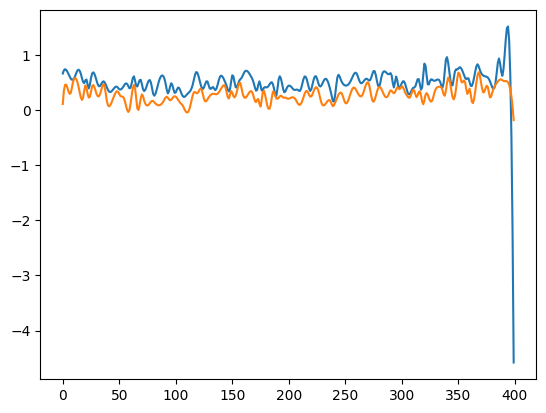

In [124]:
signal = tsdframe.loc[17]
analytic_signal = hilbert(signal)
envelope = np.abs(analytic_signal)

# Find peaks for the upper envelope
t = np.linspace(0, (N)*T, N)
peaks_indices, _ = find_peaks(signal)
upper_envelope_func = interp1d(t[peaks_indices], signal[peaks_indices], kind='cubic', fill_value="extrapolate")
upper_envelope = upper_envelope_func(t)

# To find the lower envelope, you can find peaks in the inverted signal
troughs_indices, _ = find_peaks(-signal)
lower_envelope_func = interp1d(t[troughs_indices], signal[troughs_indices], kind='cubic', fill_value="extrapolate")
lower_envelope = lower_envelope_func(t)

# CV of upper envelope (CVUE) provides a measure of the variability of the signal's amplitude. 
# CVLE is less used for further analysis
# CV of UE and LE difference provides a measure of the signal's overall spread, e.g. severity in conditions like obstructive sleep apnea.

mean = np.mean(upper_envelope)
std = np.std(upper_envelope, ddof=1)                           # ddof=1 for sample standard deviation
CVE = (std / mean) * 100

plt.plot(upper_envelope)
plt.plot(lower_envelope)
print(f"mean = {mean}")
print(f"CVE = {CVE}")

# Below is a draft work

In [27]:
# Initialize an empty list
signal_list = []
max_power_index_list = []
frequency_at_max_power_list = []

for i in range(0, last_index):
    signal = filter_tsdframe.loc[i]
    mean_psd = nap.compute_mean_power_spectral_density(signal, interval_size=100*T, fs=1/T)
    max_power_index = np.argmax(mean_psd)                            # get index of maximum PSD
    frequency_at_max_power = mean_psd.index[max_power_index]         # get corresponding frequency
    signal_list.append(i)
    max_power_index_list.append(max_power_index)                     # loop and append data to list
    frequency_at_max_power_list.append(frequency_at_max_power)       # loop and append data to list
   
# Convert the list to DataFrame 
max_psd = {'Signal': signal_list, 'Index of max power': max_power_index_list, 'Freq at max power': frequency_at_max_power_list}
max_psd_df = pd.DataFrame(max_psd)
print(max_psd_df)

    Signal  Index of max power  Freq at max power
0        0                  11           0.397112
1        1                  11           0.397112
2        2                   9           0.324910
3        3                  11           0.397112
4        4                  11           0.397112
5        5                   7           0.252708
6        6                   9           0.324910
7        7                   8           0.288809
8        8                  11           0.397112
9        9                   8           0.288809
10      10                  11           0.397112
11      11                   8           0.288809
12      12                  11           0.397112
13      13                  13           0.469314
14      14                  11           0.397112
15      15                  10           0.361011
16      16                  10           0.361011
17      17                   9           0.324910
18      18                  11           0.397112


ROIs with max frequency = loco frequency = 0.3971119133574007: [3, 4, 8, 10, 12, 14, 18, 21] 
ROIs with max frequency between 0.6 and 0.8 Hz: []
ROIs with max frequency between 0.4 and 0.6 Hz: [13]
ROIs with max frequency between 0.2 and 0.4 Hz: [2, 5, 6, 7, 9, 11, 15, 16, 17, 19, 20]
ROIs with max frequency between 0 and 0.2 Hz: [22]
ROIs with max frequency > loco frequency: []


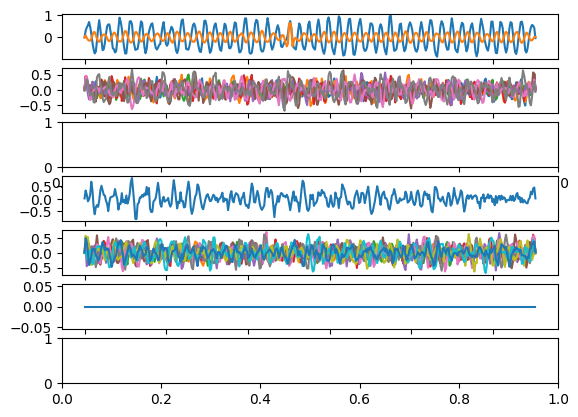

In [28]:
equal_list = []
list1 = []
list2 = []
list3 = []
list4 = []
list5 = []

fig, axs = plt.subplots(7,1) 
plt.sca(axs[0])
plt.plot(filter_tsdframe.loc[0])
plt.plot(filter_tsdframe.loc[1])

for i in range(2, last_index):
    if max_psd_df.iloc[i, 2] == max_psd_df.iloc[0, 2]:
        equal_list.append(i)
        plt.sca(axs[1])    
        plt.plot(filter_tsdframe.loc[i], label=f"{i}")
        
    elif 0.6 <= max_psd_df.iloc[i, 2] < 0.8:
        list1.append(i)
        plt.sca(axs[2])    
        plt.plot(filter_tsdframe.loc[i], label=f"{i}")
        
    elif 0.4 <= max_psd_df.iloc[i, 2] < 0.6:
        list2.append(i)
        plt.sca(axs[3])    
        plt.plot(filter_tsdframe.loc[i], label=f"{i}")

    elif 0.2 <= max_psd_df.iloc[i, 2] < 0.4:
        list3.append(i)
        plt.sca(axs[4])    
        plt.plot(filter_tsdframe.loc[i], label=f"{i}")
        
    elif 0 <= max_psd_df.iloc[i, 2] < 0.2:
        list4.append(i)
        plt.sca(axs[5])    
        plt.plot(filter_tsdframe.loc[i], label=f"{i}")

    else:
        list5.append(i)
        plt.sca(axs[6])    
        plt.plot(filter_tsdframe.loc[i], label=f"{i}")

print(f"ROIs with max frequency = loco frequency = {max_psd_df.iloc[0, 2]}: {equal_list} ")
print(f"ROIs with max frequency between 0.6 and 0.8 Hz: {list1}")
print(f"ROIs with max frequency between 0.4 and 0.6 Hz: {list2}")
print(f"ROIs with max frequency between 0.2 and 0.4 Hz: {list3}")
print(f"ROIs with max frequency between 0 and 0.2 Hz: {list4}")
print(f"ROIs with max frequency > loco frequency: {list5}")

In [29]:
for i in range(0, last_index):
    fftclean.iloc[:, i] = ifft(fftclean.iloc[:, i].values).real

ffilt = np.fft.ifft(fftclean)


#plt.plot(np.abs(fftclean))

# Convert dataframe to numpy before it can be used with ifft()
fft_numpy = fft.to_numpy
fft_numpy_filled = np.nan_to_num(fft_numpy, nan=0.0)
fft_real = np.real(fft_numpy_filled)
print(fft_real)

#fft_numeric = np.array(fft_numpy, dtype=complex)   # or dtype=float if only real numbers
#fft_of_signal = fft(df['Signal'].values)

ffilt = np.fft.ifft(fft_numeric)                   # inverse FFT for filtered time signal
reconstructed_signal = ifft(fft_real)

#reconstructed_signal = ifft(fft.iloc[1].values)
#reconstructed_signal_real = np.real(reconstructed_signal)

#plt.plot(time, ffilt, color = 'k', linewidth = 2, label = 'filtered')
plt.plot(reconstructed_signal)

<bound method DataFrame.to_numpy of                           0                   1                   2   \
0.000000  0.006280+0.000000j -0.000646+0.000000j  0.000465+0.000000j   
0.009064  0.006285+0.000084j -0.000646-0.000021j  0.000465+0.000008j   
0.018129  0.006301+0.000169j -0.000646-0.000042j  0.000465+0.000017j   
0.027193  0.006327+0.000255j -0.000647-0.000064j  0.000466+0.000025j   
0.036257  0.006364+0.000343j -0.000647-0.000085j  0.000467+0.000033j   
0.045321  0.006413+0.000433j -0.000647-0.000108j  0.000469+0.000042j   
0.054386  0.006475+0.000527j -0.000648-0.000131j  0.000468+0.000050j   
0.063450  0.006553+0.000622j -0.000647-0.000155j  0.000477+0.000070j   
0.072514  0.006637+0.000725j -0.000646-0.000177j  0.000486+0.000055j   
0.081578  0.006764+0.000833j -0.000639-0.000212j  0.000483+0.000069j   
0.090643  0.006791+0.000950j -0.000630-0.000236j  0.000584+0.000193j   
0.099707  0.007134+0.000986j -0.000680-0.000214j  0.000481+0.000068j   
0.108771  0.007129+0.000904j

NameError: name 'fft_numeric' is not defined

# Fast Fourier Transform

In [ ]:
# compute the fast fourier transform (FFT)
clean_numpy = filter_tsdframe.to_numpy()                     # convert pynapple tsdframe to numpy

dt = T                                                      # 1/fs
n = len(time)                                               # number of frames
fhat = np.fft.fft(clean_numpy, n)                           # compute the FFT
PSD = fhat * np.conj(fhat) / n                              # power spectrum (power in frequency domain)
freq = (1/(dt * n)) * np.arange(n)                          # create x-axis of frequencies
L = np.arange(1, np.floor(n/2), dtype = 'int')              # only plot the first half

# Generate FFT
fft_output = np.fft.fft(clean_numpy)
# Generate the frequency bins for the FFT output.
frequencies = np.fft.fftfreq(n, d=T)    
# Get the absolute magnitudes of the FFT output (ignoring negative frequencies)
magnitudes = np.abs(fft_output[:n//2])                
positive_frequencies = frequencies[:n//2]
# Find the index of the maximum magnitude
dominant_frequency_index = np.argmax(magnitudes)
# Get the dominant frequency
dominant_frequency = positive_frequencies[dominant_frequency_index]

print(f"The dominant frequency of the wave is: {dominant_frequency} Hz")

plt.plot(freq[L], PSD[L], linewidth = 1)
plt.show()

In [ ]:
print(clean_numpy.shape)

# Use PSD to filter out noise

In [ ]:
indices = PSD > 0.003                     # find all freqs with large power
PSDclean = PSD * indices                    # find out all others
fhat = indices * fhat                       # zero out small fourier coeff. in Y
fhat_scaled = 0.1 * fhat
ffilt = np.fft.ifft(fhat)                   # inverse FFT for filtered time signal

#plt.plot(time, ffilt, color = 'k', linewidth = 2, label = 'filtered')
plt.plot(ffilt)
plt.show()

In [ ]:
# Filter PSD from Pynapple mean PSD

# Define ROI
roi_filtered = filter_tsdframe.loc[3]

mean_psd_nerve1_filtered = nap.compute_mean_power_spectral_density(nerve1_filtered, interval_size=100*T, fs=1/T)
mean_psd_nerve2_filtered = nap.compute_mean_power_spectral_density(nerve2_filtered, interval_size=100*T, fs=1/T)
mean_psd_roi_filtered = nap.compute_mean_power_spectral_density(roi_filtered, interval_size=100*T, fs=1/T)

mean_psd_roi = pd.DataFrame()
filtered_roi = list(range(2, last_index))                # specify indices of all ROIs

for roi in filtered_roi:
    mean_psd_roi_filtered = nap.compute_mean_power_spectral_density(filter_tsdframe.loc[roi], interval_size=100*T, fs=1/T)
    mean_psd_roi[roi] = mean_psd_roi_filtered


indices = PSD > 0.003                     
PSDclean_nerve1 = mean_psd_nerve1_filtered * indices 
PSDclean_nerve2 = mean_psd_nerve2_filtered * indices 
PSDclean_roi = mean_psd_roi_filtered * indices 
fhat_nerve1 = indices * fhat                       # zero out small fourier coeff. in Y
fhat_scaled = 0.1 * fhat
ffilt = np.fft.ifft(fhat)                   # inverse FFT for filtered time signal

#plt.plot(time, ffilt, color = 'k', linewidth = 2, label = 'filtered')
plt.plot(ffilt)
plt.show()